**This notebook is the executable version of lab note 3.
It answers the following questions:**

Finally, we answer 4 items:

    1. Are successful creators more connected to high-outdegree users than do unsuccessful creators?
    2. Are mavens more connected to successful creators thanto unsuccessful creators?
    3. Do successful creators send more non-follow actions towards mavens than to zombies?
    4. Do successful creators send more non-follow actions towards mavens than to stars?

    

In [1]:
#Run parameters
#used to control every run. Can be user to perfom sensitivity checks
path_dir = r"/Users/../Volumes/Raw/"

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from collections import Counter
from src.utils import import_dta, import_tracks_dta,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import numpy as np
import datetime
import pandas as pd
from tqdm import tqdm
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import os
from statsmodels.stats.proportion import proportions_ztest

In [3]:
def process_date(date):
    '''convert date format like '2013-w09' to '2013-03-04', i.e. the first day of that week'''
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.datetime.strptime(date, "%Y-%W-%w")
    return dt

# Data Imports

We start by importing the raw data.  `follows_sent`, `comments_sent`, `shares_sent`, `likes_sent` and `messages_sent` contains data pn the promotional activities that the 35k users tracked in the dataset directed to other users. It includes the `user_id`, the `fan_id` and the `date_sent` which identifies the date when the prom. activity was sent. `users_info_1st` shows the type of user (creator or non-creator, which is identified by a blank) and the date the user entered the platform, for every user that sent or received prom. activities from any of the 35k users tracked in this dataset, while `users_info` contains the same information, but pertaining to the 35k users themselves.

`follows_received` contains information on the follows received by the 35k users and will be used to generate the successful/unsuccessful groups of content creators.

In [4]:
#affiliations :follows
#favoritings :likes

#used in filtering:
path_dir = r"/Users/../Volumes/Raw/"
tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");

#these are the actions sent to 
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

#Used to track information on the 1st degree connections
user_info_1st = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_1st.columns = ['user_id', 'type', 'entered_platform'];
user_info = import_dta(path_dir, "12sample_user_infos.dta");

#Used to compute creator's success measure
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)


Indegree and outdegree information.

The function below import the outdegree dataset. Because the raw version of those dataset are too large to be processed in memory, we preprocessed them in a separate script.

In [5]:
# Aggregates preprocessed outdegree of 1st degree users
def import_outdegree(path='/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/'):
    d = {}
    for i in range(6):
       d[str(i)] = pd.read_pickle(os.path.join(path,'{}.pkl'.format(i))) 
       d[str(i)]['created_at'] =  pd.to_datetime(d[str(i)]['created_at'])
       d[str(i)]['created_at'] = pd.to_datetime(d[str(i)]['created_at']).dt.floor('d')
       d[str(i)] = d[str(i)].groupby(['sender_id', 'created_at'], as_index = False).size() 
    
    data_outdegree = pd.concat([d['0'], d['1'], d['2'], d['3'], d['4'], d['5']])
    #data_outdegree.set_index('created_at', inplace = True)
    return data_outdegree

In [6]:
data_outdegree = import_outdegree()

In [7]:
#data_outdegree = data_outdegree.groupby(['sender_id','created_at'], as_index = False).size()

# Preprocessing

## Creator ids, successful and unsucessful creators

Next, we define three lists of ids: one with the ids from the content creators, according to the `users_info` table, one with the ids of successful creators and the last one with the ids of the unsuccessful ones.

Let's start with a list of the id of creators. We also create a dataset with containing information on creators only.

In [8]:
mask = (tracks.track_available == 1) & (tracks.public == 't')
creator_ids = tracks[mask].user_id.unique()

creators = tracks[(tracks.track_available == 1) & (tracks.public == 't')]

#mask = user_info.type == 'creator'
#creator_ids = user_info[mask].user_id.unique()

#creators = user_info[user_info.type == 'creator']

In [9]:
def successful_creators_followers(follows_received, base_date = datetime.datetime(2016, 5, 30, 0, 0), perc1 = None, perc2 = None, subset_creators = None):
    '''Classifies content creators in successful or unsuccessfull
        Arguments:
                    follows_received: dataframe containing the follows received by content creators
                    base date:        date, in datetime.datetime(YYYY, M, DD, H, M) format, in which the number 
                                      of followers per creator is calculated.
                    perc1:            the threshold used to classify unsuccessful content creators. Creator having 
                                      total followers below the number dictated by this threshold, at the base date,
                                      are classified as unsuccessful 
                    perc2:            the threshold used to classify successful content creators. Creator having 
                                      total followers above the number dictated by this threshold, at the base date,
                                      are classified as successful
                    subset_creators:  a pd.DataFrame containing the creators. If is it available, it will be used to 
                                      filter out non creators and to make sure creators with 0 followers are part of
                                      the resulting dataset.
        
    '''
    print(base_date)

    if 'inbound_activity' not in follows_received.columns:
        follows_received.columns = ['fan_id', 'user_id', 'date_sent']

    mask = (follows_received['date_sent'] < base_date)

    df = follows_received[mask].groupby('user_id', as_index=False).agg({'fan_id': pd.Series.nunique})
    df.columns = ['user_id', 'followers']

    
    if type(subset_creators) == pd.DataFrame:
        print('subsetting...')
        df.set_index('user_id', inplace = True)
        df = df.reindex(subset_creators.user_id.unique())
        df.fillna(0, inplace = True)
        df.reset_index(inplace = True)
        df.columns = ['user_id', 'followers']

    low = np.quantile(df.followers, perc1)
    high = np.quantile(df.followers, perc2)

    print("High influencer boundary: {}".format(high))
    print("Low influencer boundary: {}".format(low))

    mask = (df["followers"] <= low) | (df["followers"] >= high)
    
    unsuccessful_creator_ids = df.loc[df["followers"] <= low].user_id.unique()
    successful_creator_ids = df.loc[df["followers"] >= high].user_id.unique()

    return unsuccessful_creator_ids, successful_creator_ids

## Putting together a dataset with the promotional activities made by content creators.

The function `gen_actions_sent_df` creates a dataframe with all the promotional activities that content creators sent to users.

In [10]:
def gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent, messages_sent, creator_ids = creator_ids):
    '''
    Creates dataframe containing the actions that content creators send to users.
        Attributes:
                    follows_sent:  dataframe with the follows sent by the 35k users.
                    shares_sent:   dataframe with the shares sent by the 35k users.
                    likes_sent:    dataframe with the likes sent by the 35k users.
                    comments_sent: dataframe with the comments sent by the 35k users.
                    messages_sent: dataframe with the messages sent by the 35k users.
                    creator_ids:   list with content creator ids. If not none, is used to
                                   filter out activities from non creators.
    '''
    
    follows_sent['outbound_activity'] = 'follow'
    follows_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'song_id' in shares_sent.columns:
        shares_sent.drop(columns=["song_id"])
    shares_sent = shares_sent[['reposter_id', "owner_id", 'created_at']]
    shares_sent['outbound_activity'] = 'share'
    shares_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in likes_sent.columns:
        likes_sent.drop(columns=["track_id"], inplace=True)
    likes_sent['outbound_activity'] = 'like'
    likes_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in comments_sent.columns:
        comments_sent.drop(columns=["track_id"], inplace=True)
    comments_sent['outbound_activity'] = 'comment'
    comments_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    messages_sent["outbound_activity"] = 'message'
    messages_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']
    df = pd.concat([follows_sent, shares_sent, likes_sent, comments_sent, messages_sent])


    if type(creator_ids) == numpy.ndarray:
        df = df[df['user_id'].isin(creator_ids)]
        
    df['week_yr'] = df.date_sent.dt.strftime('%Y-w%U')
    df = df.loc[df['user_id'] != df['fan_id'],:]

    return df

In [11]:
actions_sent = gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent,
                                     messages_sent, creator_ids = None)

## Filter only actions that were sent to non-fans

We merge the `actions_sent` dataset with a table containing the date each fan started following the creator.

In [12]:
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follows_received[["fan_id", "user_id", "date_sent"]]
followers.columns = ["fan_id", "user_id", "follower_since"]

actions_sent = actions_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

Since we are interested in acquisition campaings, we need to produce a dataset that exclude actions targetting fans.
We do that using filters based on the date of the action and the date that the user became a fan of the content creator. The resulting dataframe is named `actions_sent_non_fans`.

We then filter only actions that happened before the user follows the content creator.

In [13]:
mask = (actions_sent.date_sent < actions_sent.follower_since) | (actions_sent.follower_since.isnull())
actions_sent_non_fans =  actions_sent[mask]
actions_sent_non_fans['week_yr_date'] = actions_sent_non_fans.week_yr.apply(lambda x: process_date(x))

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/3855957735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['week_yr_date'] = actions_sent_non_fans.week_yr.apply(lambda x: process_date(x))


## Outdegree level

Originally, we only have outdegree information on users that follow at least one user. The function below inputs an outdegree of 0 to users that are following anyone.

In [14]:
#CHANGE DOCUMENTATION
def outdegree_level(data, date, user_info = user_info_1st):
    
    '''
    This function returns the membership table at date equals `date`. Every user that interacted with the 35k tracked 
    users and entered the platform before `date` is present in the table, even if it has indegree 0.
    arguments:
              data:           the indegree dataset.
              user_info:      the dataset containing all the users that interacted with the 35k users tracked.
    '''
    
    data = data[data.created_at.dt.floor('d')<=date]
    data = data.groupby('sender_id').agg({'size':'sum'}).compute()
    
    #merge with user info to obtain users that are not followed by anyone at the current date
    data = user_info_1st.merge(data, left_on = 'user_id', right_on = 'sender_id', how= 'outer')
    data.loc[data['size'].isnull(), 'size'] = 0
    data = data[['user_id', 'size', 'entered_platform']].set_index('user_id')
    
    #filter out users that didnt exist in the current date
    mask = data['entered_platform'].dt.floor('d') <= date
    data = data.loc[mask]
    
    mask = (data['size']>0)
    data.loc[~mask, 'size'] = 0 
    
    return data

In [15]:
#dask is a python api with objects optimized for big data (user directed acyclic graphs). 
dask_outdegree = dd.from_pandas(data_outdegree, npartitions = 3)

In [16]:
last_day =  max(actions_sent.date_sent.dt.floor('d').unique())
user_outdegree = outdegree_level(dask_outdegree, last_day, user_info = user_info_1st)
receiver_ids = user_outdegree.index.unique()

Now we classify the creator in successful and unsuccessful, according to the threshold defined in the beggining of this notebook.

In [17]:
def user_outdegree_level(oudegree_data, perc1 = None, perc2 = None):
    '''Classifies content creators in successful or unsuccessfull
        Arguments:
                    oudegree_data:    dataframe containing the fans followers at 
                    perc1:            the threshold used to classify unsuccessful content creators. Creator having 
                                      total followers below the number dictated by this threshold, at the base date,
                                      are classified as unsuccessful 
                    perc2:            the threshold used to classify successful content creators. Creator having 
                                      total followers above the number dictated by this threshold, at the base date,
                                      are classified as successful
    '''

    df = oudegree_data.reset_index().iloc[:,:2]
    df.columns = ['user_id', 'followers']

    low = np.quantile(df.followers, perc1)
    high = np.quantile(df.followers, perc2)

    print("High outdegree boundary: {}".format(high))
    print("Low outdegree boundary: {}".format(low))
    
    low_outdegree_ids = df.loc[df["followers"] <= low].user_id.unique()
    high_outdegree_ids = df.loc[df["followers"] >= high].user_id.unique()
    
    
    df['outdegree_level'] = df.user_id.apply(
        lambda x: 'high' if x in high_outdegree_ids else ('low' if x in low_outdegree_ids else None))

    
    return df, low_outdegree_ids, high_outdegree_ids

## Non-follow Actions level

The activity level is defined as the number of actions performed by users. It is important to notice that we only observe actions targeting the 35k users that joined in march 2012. We consider this measure a proxy for the real activity level.

Let's begin by creating a dataset with all action received by those 35k users.

In [18]:
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)


In [19]:
if 'song_id' in shares_received:
        shares_received.drop(columns=["song_id"])
shares_received = shares_received[['reposter_id', "owner_id", 'created_at']]
shares_received['inbound_activity'] = 'share'
shares_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

if 'track_id' in likes_received:
        likes_received = likes_received.drop(columns=["track_id"])
likes_received['inbound_activity'] = 'like'
likes_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

if 'track_id' in comments_received:
        comments_received = comments_received.drop(columns=["track_id"])
comments_received['inbound_activity'] = 'comment'
comments_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

messages_received["outbound_activity"] = 'message'
messages_received.columns = ['user_id', 'fan_id', 'date_sent', 'inbound_activity']

In [20]:
user_activity_data = pd.concat([shares_received, likes_received, comments_received, messages_received])

In [21]:
def user_activity_level(user_activity_data, receiver_ids, perc1 = None, perc2 = None):
    '''Classifies users based on the amount of non-follow activities
        Arguments:
                    user_activity_data:   dataframe containing the user activities 
                    base date:             date, in datetime.datetime(YYYY, M, DD, H, M) format, in which the number 
                                           of followers per creator is calculated.
                    perc1:                 the threshold used to classify unsuccessful content creators. Creator having 
                                           total followers below the number dictated by this threshold, at the base date,
                                           are classified as unsuccessful 
                    perc2:                 the threshold used to classify successful content creators. Creator having 
                                           total followers above the number dictated by this threshold, at the base date,
                                           are classified as successful
    '''

    df = user_activity_data.groupby('fan_id', as_index = True).size()
    df = df.reindex(receiver_ids)
    print(df.shape)
    df = df.reset_index()
    df.columns = ['user_id', 'activities_performed']
    
    df.loc[df.activities_performed.isna(), 'activities_performed'] = 0
    #classification should happen after this

    low = np.quantile(df.activities_performed, perc1)
    high = np.quantile(df.activities_performed, perc2)

    print("High activity boundary: {}".format(high))
    print("Low activity boundary: {}".format(low))
    
    low_activity_ids = df.loc[df["activities_performed"] <= low].user_id.unique()
    high_activity_ids = df.loc[df["activities_performed"] > high].user_id.unique()
    
    df['activity_level'] = df.user_id.apply(
    lambda x: 'high' if x in high_activity_ids else ('low' if x in low_activity_ids else None))

    return df, low_activity_ids, high_activity_ids

# Testing

Finally, we answer 4 items:

    1. Are successful creators more connected to high-outdegree users than do unsuccessful creators?
    2. Are mavens more connected to successful creators thanto unsuccessful creators?
    3. Do successful creators send more non-follow actions towards mavens than to zombies?
    4. Do successful creators send more non-follow actions towards mavens than to stars?

In [22]:
import numpy as np
import scipy.stats as stats

def calculate_odds_ratio_ci(exposed_cases, exposed_controls, nonexposed_cases, nonexposed_controls):
    # Calculate the odds ratio (OR)
    odds_ratio = (exposed_cases / exposed_controls) / (nonexposed_cases / nonexposed_controls)

    # Calculate the 95% confidence interval (CI) for the OR
    log_odds_ratio = np.log(odds_ratio)
    std_error = np.sqrt(1/exposed_cases + 1/exposed_controls + 1/nonexposed_cases + 1/nonexposed_controls)
    z_score = stats.norm.ppf(0.975)
    lower_ci = np.exp(log_odds_ratio - z_score*std_error)
    upper_ci = np.exp(log_odds_ratio + z_score*std_error)

    return round(odds_ratio, 2), round(lower_ci, 2), round(upper_ci, 2)

In [23]:
def odds_ratio(g1, g2, group_ids1, group_ids2):
    
    tab = np.array([[g1, g2], [len(group_ids1)-g1, len(group_ids2)-g2]])

    # calculate the odds ratio by taking the ratio of the odds of the event occurring in the two groups
    odds_ratio = (g1/(len(group_ids1)-g1)/(g2/(len(group_ids2)-g2)))
    print("Odds Ratio:", round(odds_ratio,4))

    # perform a chi-square test to determine whether the observed odds ratio is statistically significant
    chi2, p_value, _, _ = chi2_contingency(tab)
    print("Chi-Square Statistic:", round(chi2,4))
    print("P-Value:", round(p_value,4))

## Data Preparation

In [37]:
Robustness_table = pd.DataFrame(index = ['0.1, 0.9', '0.25, 0.75'],columns = [ 
                'Q1_OR_Outdegree_threshold_0.1, 0.9','Q1_OR_Outdegree_threshold_0.25, 0.75',
                'Q2_OR_Outdegree_threshold_0.1, 0.9','Q2_OR_Outdegree_threshold_0.25, 0.75'])

In [25]:
low_success = 0.5 #below the median: unsuccessful
high_success = 0.9 #top 10% creators with more followers are deemed successful

low_user_outdegree = 0.1 
high_user_outdegree = 0.9 

low_user_activity = 0.1 
high_user_activity = 0.9 

In [56]:
def gen_datasets(low_success, high_success, low_user_outdegree, high_user_outdegree, low_user_activity, high_user_activity): 
    unsuccessful_ids, successful_ids = successful_creators_followers(follows_received, 
                    perc1 = low_success, perc2 = high_success, subset_creators = creators)

    user_outdegree_df, low_outdegree_ids, high_outdegree_ids = user_outdegree_level(user_outdegree,
                    perc1 = low_user_outdegree, perc2 = high_user_outdegree)

    activity_level, low_activity_ids, high_activity_ids = user_activity_level(user_activity_data, receiver_ids, 
                    perc1 = low_user_activity, perc2 = high_user_activity)

    table_data = user_outdegree_df.merge(activity_level, left_on = 'user_id', right_on = 'user_id', how = 'inner')

    table_data['Type'] = table_data.apply(lambda x: 
        'Maven' if (x.outdegree_level == 'low') & (x.activity_level == 'high')
         else ('Zombie' if (x.outdegree_level == 'low') & (x.activity_level == 'low')
         else ('Stalker' if (x.outdegree_level == 'high') & (x.activity_level == 'low')
         else ('Star' if (x.outdegree_level == 'high') & (x.activity_level == 'high')
         else 'other'))), axis=1)

    zombie_ids = table_data.loc[table_data.Type =='Zombie'].user_id.unique()
    star_ids = table_data.loc[table_data.Type =='Star'].user_id.unique()
    maven_ids = table_data.loc[table_data.Type =='Maven'].user_id.unique()
    stalker_ids = table_data.loc[table_data.Type =='Stalker'].user_id.unique()

    actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else 
                              ('Zombie' if x in zombie_ids else
                              ('Stalker' if x in stalker_ids else
                              ('Star' if x in star_ids else 'other'))))

    ## classify content creators
    actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(
                                                lambda x: 'successful' if x in successful_ids else 
                                                ('unsuccessful' if x in unsuccessful_ids else 'other'))
    
    return table_data, successful_ids, unsuccessful_ids, actions_sent_non_fans, maven_ids, star_ids, zombie_ids, stalker_ids

In [133]:
low_success = 0.5
high_success = 0.9
Robustness_table = pd.DataFrame(index = ['0.1, 0.9', '0.25, 0.75', '0.5, 0.5'],
                                columns = [ 
                'Q1_OR_Activity_threshold_0.1, 0.9',
                'Q1_OR_Activity_threshold_0.05, 0.95',
                'Q2_OR_Activity_threshold_0.1, 0.9',
                'Q2_OR_Activity_threshold_0.05, 0.95',
                'Q3_OR_Activity_threshold_0.1, 0.9',
                'Q3_OR_Activity_threshold_0.05, 0.95',
                'Q4_OR_Activity_threshold_0.1, 0.9',
                'Q4_OR_Activity_threshold_0.05, 0.95'                
])
for low_user_activity, high_user_activity in ([(0.1, 0.9), (0.05, 0.95)]): 
    for low_user_outdegree, high_user_outdegree in ([(0.1, 0.9), (0.25, 0.75), (0.5, 0.5)]):
        table_data, successful_ids, unsuccessful_ids, actions_sent_non_fans, maven_ids, star_ids, zombie_ids, stalker_ids = gen_datasets(low_success,
           high_success, low_user_outdegree, high_user_outdegree, low_user_activity, high_user_activity) 

        #OR1
        table_data.columns = ['fan_id', 'followers', 'outdegree_level', 'activities_performed', 'activity_level', 'Type']
        table = follows_received.merge(table_data, left_on = 'fan_id', right_on = 'fan_id', how = 'inner') #suffixes

        table['creator_type'] = table.user_id.apply(
                                                    lambda x: 'successful' if x in successful_ids else 
                                                    ('unsuccessful' if x in unsuccessful_ids else 'other'))
        table1 = table.groupby(['creator_type','outdegree_level'], as_index = False).size()
        mask = (table1.outdegree_level == 'high') & (table1.creator_type == 'successful')
        g1 = table1.loc[mask]['size'].values[0]

        mask = (table1.outdegree_level == 'high') & (table1.creator_type == 'unsuccessful')
        g2 = table1.loc[mask]['size'].values[0]
        group_ids1 = table.loc[table.creator_type == 'successful']
        group_ids2 = table.loc[table.creator_type == 'unsuccessful']

        Robustness_table.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'Q1_OR_Activity_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = calculate_odds_ratio_ci(g1, g2, len(group_ids1)-g1, len(group_ids2)-g2)[0]

        #OR2

        table1 = table.groupby(['creator_type','Type'], as_index = False).size()

        mask = (table1.Type == 'Maven') & (table1.creator_type == 'successful')
        g1 = table1.loc[mask]['size'].values[0]

        mask = (table1.Type == 'Maven') & (table1.creator_type == 'unsuccessful')
        g2 = table1.loc[mask]['size'].values[0]
        group_ids1 = table.loc[table.creator_type == 'successful']
        group_ids2 = table.loc[table.creator_type == 'unsuccessful']

        Robustness_table.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'Q2_OR_Activity_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = calculate_odds_ratio_ci(g1, g2, len(group_ids1)-g1, len(group_ids2)-g2)[0]
        
        #OR3
        
        distribution_target_user_type = actions_sent_non_fans.groupby(['creator_type', 'user_type']).fan_id.nunique()
        dist_target_user = distribution_target_user_type.to_frame().reset_index()
        dist_target_user.columns = ['creator_type', 'user_type', 'non_follow_actions']
        
        mask = (dist_target_user.user_type == 'Maven') & (dist_target_user.creator_type == 'successful')
        g1 = dist_target_user.loc[mask].non_follow_actions.values[0]

        mask = (dist_target_user.user_type == 'Zombie') & (dist_target_user.creator_type == 'successful')
        g2 = dist_target_user.loc[mask].non_follow_actions.values[0]

        group_ids1 = maven_ids
        group_ids2 = zombie_ids
        
        
        Robustness_table.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'Q3_OR_Activity_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = calculate_odds_ratio_ci(g1, g2, len(group_ids1)-g1, len(group_ids2)-g2)[0]

        #OR4
        
        mask = (dist_target_user.user_type == 'Maven') & (dist_target_user.creator_type == 'successful')
        g1 = dist_target_user.loc[mask].non_follow_actions.values[0]

        mask = (dist_target_user.user_type == 'Star') & (dist_target_user.creator_type == 'successful')
        g2 = dist_target_user.loc[mask].non_follow_actions.values[0]

        group_ids1 = maven_ids
        group_ids2 = star_ids
        
        Robustness_table.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'Q4_OR_Activity_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = calculate_odds_ratio_ci(g1, g2, len(group_ids1)-g1, len(group_ids2)-g2)[0]


2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 772.0
Low outdegree boundary: 1.0
(670746,)
High activity boundary: 0.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 162.0
Low outdegree boundary: 17.0
(670746,)
High activity boundary: 0.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 56.0
Low outdegree boundary: 56.0
(670746,)
High activity boundary: 0.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 772.0
Low outdegree boundary: 1.0
(670746,)
High activity boundary: 1.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 162.0
Low outdegree boundary: 17.0
(670746,)
High activity boundary: 1.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 56.0
Low outdegree boundary: 56.0
(670746,)
High activity boundary: 1.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


In [218]:
low_success = 0.5
high_success = 0.9
Robustness_table_2 = pd.DataFrame(index = ['0.1, 0.9', '0.25, 0.75', '0.5, 0.5'],
                                columns = [ 
                'P_Success_Maven_f_threshold_0.1, 0.9',
                'P_Success_Maven_f_threshold_0.05, 0.95',
                'P_Success_Maven_nf_threshold_0.1, 0.9',
                'P_Success_Maven_nf_threshold_0.05, 0.95',
                'P_Success_Star_f_threshold_0.1, 0.9',
                'P_Success_Star_f_threshold_0.05, 0.95',
                'P_Success_Star_nf_threshold_0.1, 0.9',
                'P_Success_Star_nf_threshold_0.05, 0.95'                
])
for low_user_activity, high_user_activity in ([(0.1, 0.9), (0.05, 0.95)]): 
    for low_user_outdegree, high_user_outdegree in ([(0.1, 0.9), (0.25, 0.75), (0.5, 0.5)]):
        table_data, successful_ids, unsuccessful_ids, actions_sent_non_fans, maven_ids, star_ids, zombie_ids, stalker_ids = gen_datasets(low_success,
           high_success, low_user_outdegree, high_user_outdegree, low_user_activity, high_user_activity) 

        
        bdf = pd.DataFrame(creator_ids, columns = ['creator_id'])
        bdf['successful'] = bdf.creator_id.apply(lambda x: 1 if x in successful_ids else 0)

        #follow
        mask = (actions_sent_non_fans.outbound_activity == 'follow')
        Mavens_targeted_follow = actions_sent_non_fans[(mask)
                        & (actions_sent_non_fans.user_type == 'Maven')].groupby('user_id', as_index = False).size()
        Mavens_targeted_follow.columns = ['creator_id', 'Mavens_targeted_follow']

        Stars_targeted_follow =  actions_sent_non_fans[(mask)
                        & (actions_sent_non_fans.user_type == 'Star')].groupby('user_id', as_index = False).size()
        Stars_targeted_follow.columns = ['creator_id', 'Stars_targeted_follow']

        bdf = bdf.merge(Mavens_targeted_follow, left_on = 'creator_id', right_on='creator_id', how = 'left')
        bdf = bdf.fillna(0)
        bdf = bdf.merge(Stars_targeted_follow, left_on = 'creator_id', right_on='creator_id', how = 'left')
        bdf = bdf.fillna(0)

        bdf['followed_Maven'] = (bdf.Mavens_targeted_follow > 0)*1
        bdf['followed_Star'] = (bdf.Stars_targeted_follow > 0)*1


        P_A_and_B = bdf.loc[(bdf.successful == 1) & (bdf.followed_Maven == 1)].shape[0]/bdf.shape[0]
        P_B = bdf.loc[(bdf.followed_Maven == 1)].shape[0]/bdf.shape[0]
        P_success_g_Maven = round(P_A_and_B/P_B,2)
        
        Robustness_table_2.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'P_Success_Maven_f_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = P_success_g_Maven

        print('P(success|Maven): {}'.format(P_success_g_Maven))

        P_A_and_B = bdf.loc[(bdf.successful == 1) & (bdf.followed_Star == 1)].shape[0]/bdf.shape[0]
        P_B = bdf.loc[(bdf.followed_Star == 1)].shape[0]/bdf.shape[0]
        P_success_g_Star = round(P_A_and_B/P_B,2)
        
        Robustness_table_2.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'P_Success_Star_f_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = P_success_g_Star
        
        print('P(success|Star): {}'.format(P_success_g_Star))
        
        #non-follow

        mask = (actions_sent_non_fans.outbound_activity != 'follow')
        Mavens_targeted_non_follow = actions_sent_non_fans[(mask)
                        & (actions_sent_non_fans.user_type == 'Maven')].groupby('user_id', as_index = False).size()
        Mavens_targeted_non_follow.columns = ['creator_id', 'Mavens_targeted_non_follow']

        Stars_targeted_non_follow =  actions_sent_non_fans[(mask)
                        & (actions_sent_non_fans.user_type == 'Star')].groupby('user_id', as_index = False).size()
        Stars_targeted_non_follow.columns = ['creator_id', 'Stars_targeted_non_follow']

        bdf = bdf.merge(Mavens_targeted_non_follow, left_on = 'creator_id', right_on='creator_id', how = 'left')
        bdf = bdf.fillna(0)
        bdf = bdf.merge(Stars_targeted_non_follow, left_on = 'creator_id', right_on='creator_id', how = 'left')
        bdf = bdf.fillna(0)

        bdf['non_follow_Maven'] = (bdf.Mavens_targeted_non_follow > 0)*1
        bdf['non_follow_Star'] = (bdf.Stars_targeted_non_follow > 0)*1
        
        
        P_A_and_B = bdf.loc[(bdf.successful == 1) & (bdf.non_follow_Maven == 1)].shape[0]/bdf.shape[0]
        P_B = bdf.loc[(bdf.non_follow_Maven == 1)].shape[0]/bdf.shape[0]
        P_success_g_Maven = round(P_A_and_B/P_B,2)
        
        Robustness_table_2.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'P_Success_Maven_nf_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = P_success_g_Maven
        print('P(success|Maven): {}'.format(P_success_g_Maven))

        P_A_and_B = bdf.loc[(bdf.successful == 1) & (bdf.non_follow_Star == 1)].shape[0]/bdf.shape[0]
        P_B = bdf.loc[(bdf.non_follow_Star == 1)].shape[0]/bdf.shape[0]
        P_success_g_Star = round(P_A_and_B/P_B,2)
        
        Robustness_table_2.loc['{}, {}'.format(low_user_outdegree, high_user_outdegree),
                             'P_Success_Star_nf_threshold_{}, {}'
        .format(low_user_activity, high_user_activity)] = P_success_g_Star
        
        print('P(success|Star): {}'.format(P_success_g_Star))

2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 772.0
Low outdegree boundary: 1.0
(670746,)
High activity boundary: 0.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


P(success|Maven): 0.44
P(success|Star): 0.45
P(success|Maven): 0.53
P(success|Star): 0.48
2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 162.0
Low outdegree boundary: 17.0
(670746,)
High activity boundary: 0.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


P(success|Maven): 0.3
P(success|Star): 0.33
P(success|Maven): 0.36
P(success|Star): 0.39
2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 56.0
Low outdegree boundary: 56.0
(670746,)
High activity boundary: 0.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


P(success|Maven): 0.27
P(success|Star): 0.29
P(success|Maven): 0.33
P(success|Star): 0.36
2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 772.0
Low outdegree boundary: 1.0
(670746,)
High activity boundary: 1.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


P(success|Maven): 0.44
P(success|Star): 0.49
P(success|Maven): 0.44
P(success|Star): 0.55
2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 162.0
Low outdegree boundary: 17.0
(670746,)
High activity boundary: 1.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


P(success|Maven): 0.33
P(success|Star): 0.39
P(success|Maven): 0.33
P(success|Star): 0.47
2016-05-30 00:00:00
subsetting...
High influencer boundary: 70.0
Low influencer boundary: 10.0
High outdegree boundary: 56.0
Low outdegree boundary: 56.0
(670746,)
High activity boundary: 1.0
Low activity boundary: 0.0


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['user_type'] = actions_sent_non_fans.fan_id.apply(lambda x: 'Maven' if x in maven_ids else
/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_26792/4105913319.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_fans['creator_type'] = actions_sent_non_fans.user_id.apply(


P(success|Maven): 0.31
P(success|Star): 0.35
P(success|Maven): 0.33
P(success|Star): 0.42


In [220]:
Robustness_table_2

,"P_Success_Maven_f_threshold_0.1, 0.9","P_Success_Maven_f_threshold_0.05, 0.95","P_Success_Maven_nf_threshold_0.1, 0.9","P_Success_Maven_nf_threshold_0.05, 0.95","P_Success_Star_f_threshold_0.1, 0.9","P_Success_Star_f_threshold_0.05, 0.95","P_Success_Star_nf_threshold_0.1, 0.9","P_Success_Star_nf_threshold_0.05, 0.95"
"0.1, 0.9",0.44,0.44,0.53,0.44,0.45,0.49,0.48,0.55
"0.25, 0.75",0.3,0.33,0.36,0.33,0.33,0.39,0.39,0.47
"0.5, 0.5",0.27,0.31,0.33,0.33,0.29,0.35,0.36,0.42


## Plots

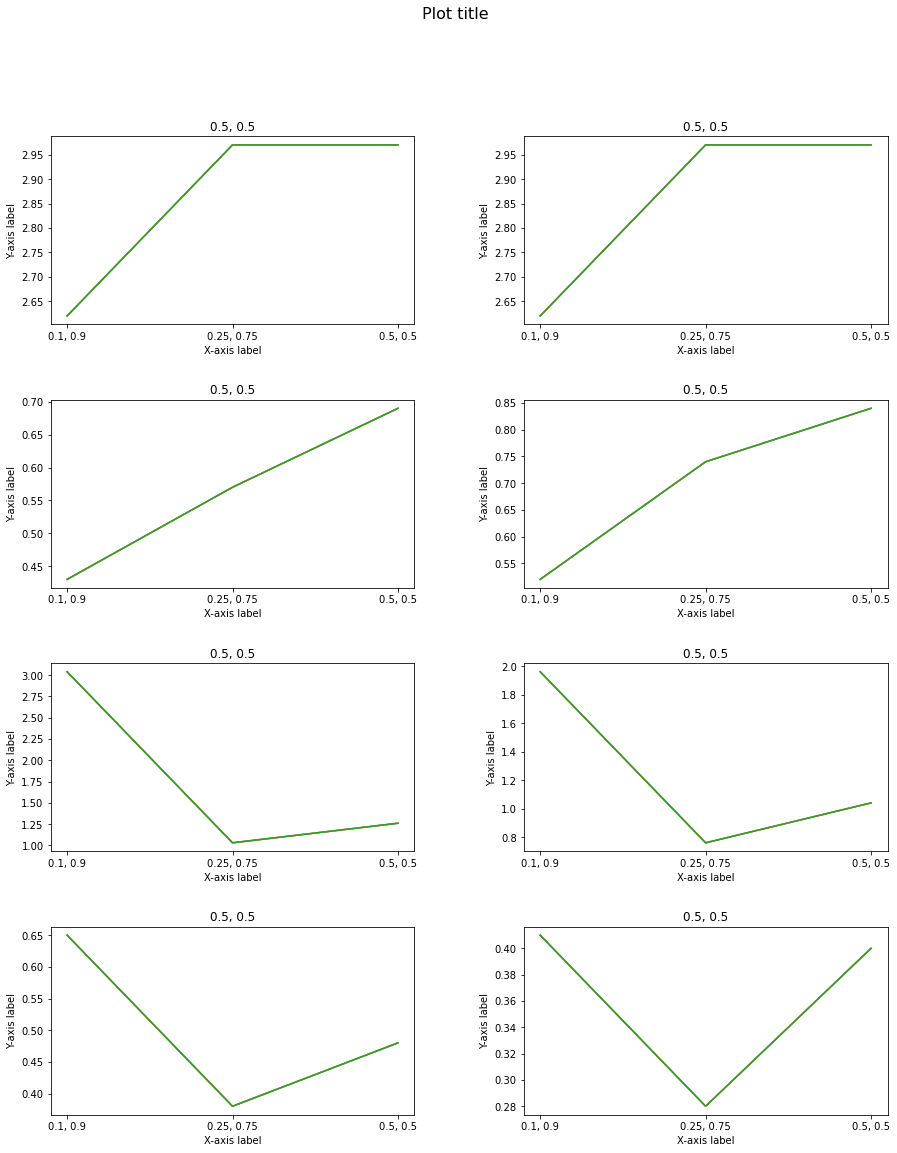

In [159]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create a sample DataFrame
df = Robustness_table
# set the x-axis values
x = ['0.1, 0.9', '0.25, 0.75', '0.5, 0.5']

# set the subplot dimensions
nrows = 4
ncols = 2

# create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))

# loop over the rows and columns of the DataFrame
for i, row in enumerate(df.iterrows()):
    for j, (col_name, data) in enumerate(row[1].iteritems()):
        # get the subplot axis
        ax = axes[j // ncols, j % ncols]
        # plot the data on the subplot
        ax.plot(x, df[col_name], label=col_name)
        # set the title of the subplot to the row name
        ax.set_title(row[0])
        # set the x-axis label
        ax.set_xlabel('X-axis label')
        # set the y-axis label
        ax.set_ylabel('Y-axis label')

# add a title to the entire plot
fig.suptitle('Plot title', fontsize=16)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# display the plot
plt.show()


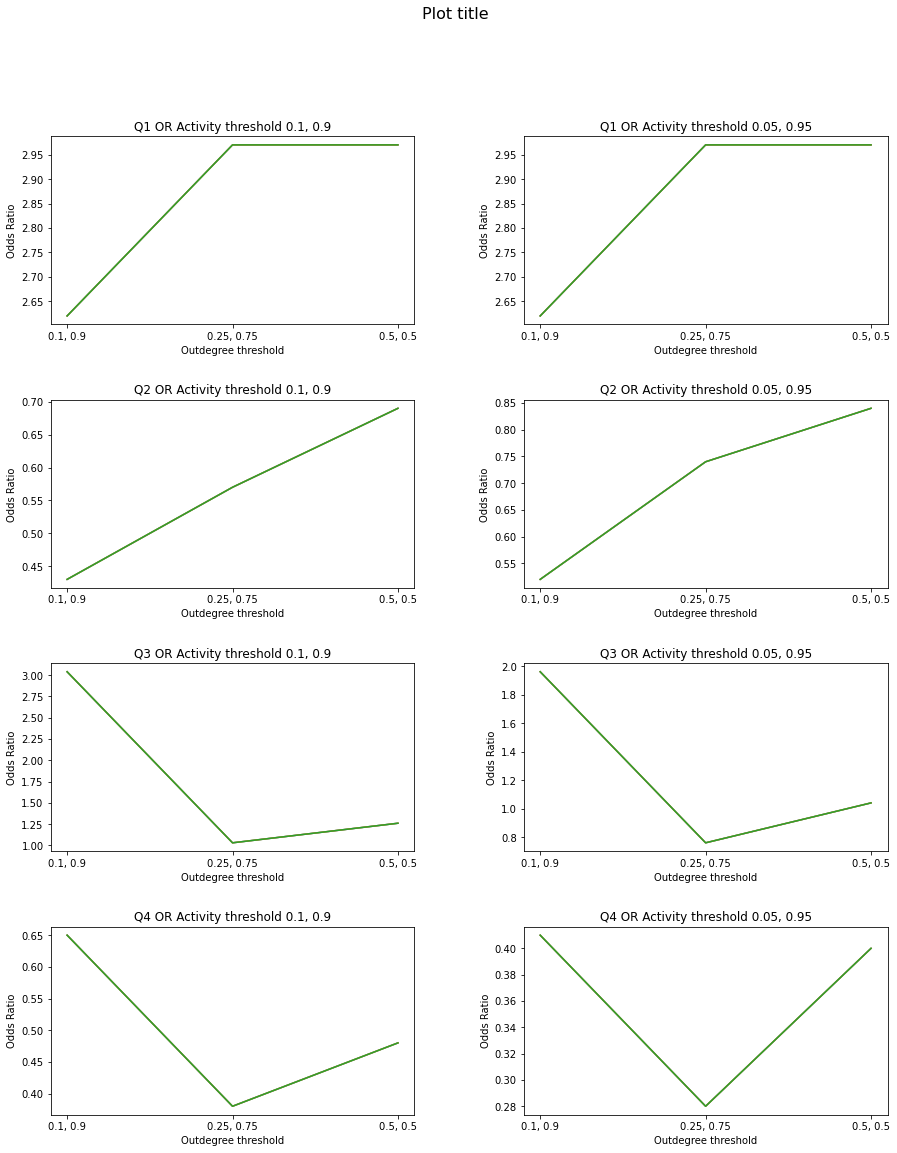

In [162]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create a sample DataFrame
df = Robustness_table
# set the x-axis values
x = ['0.1, 0.9', '0.25, 0.75', '0.5, 0.5']

# set the subplot dimensions
nrows = 4
ncols = 2

# create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))

# loop over the rows and columns of the DataFrame
for i, row in enumerate(df.iterrows()):
    for j, (col_name, data) in enumerate(row[1].iteritems()):
        # get the subplot axis
        ax = axes[j // ncols, j % ncols]
        # plot the data on the subplot
        ax.plot(x, df[col_name], label=col_name)
        # set the title of the subplot to the column name (with underscores replaced by spaces)
        ax.set_title(col_name.replace("_", " "))
        # set the x-axis label
        ax.set_xlabel('Outdegree threshold')
        # set the y-axis label
        ax.set_ylabel('Odds Ratio')

# add a title to the entire plot
fig.suptitle('Plot title', fontsize=16)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# display the plot
plt.show()


In [166]:
Robustness_table_2.columns

Index(['P_Success_Maven_f_threshold_0.1, 0.9',
       'P_Success_Maven_f_threshold_0.05, 0.95',
       'P_Success_Maven_nf_threshold_0.1, 0.9',
       'P_Success_Maven_nf_threshold_0.05, 0.95',
       'P_Success_Star_f_threshold_0.1, 0.9',
       'P_Success_Star_f_threshold_0.05, 0.95',
       'P_Success_Star_nf_threshold_0.1, 0.9',
       'P_Success_Star_nf_threshold_0.05, 0.95'],
      dtype='object')

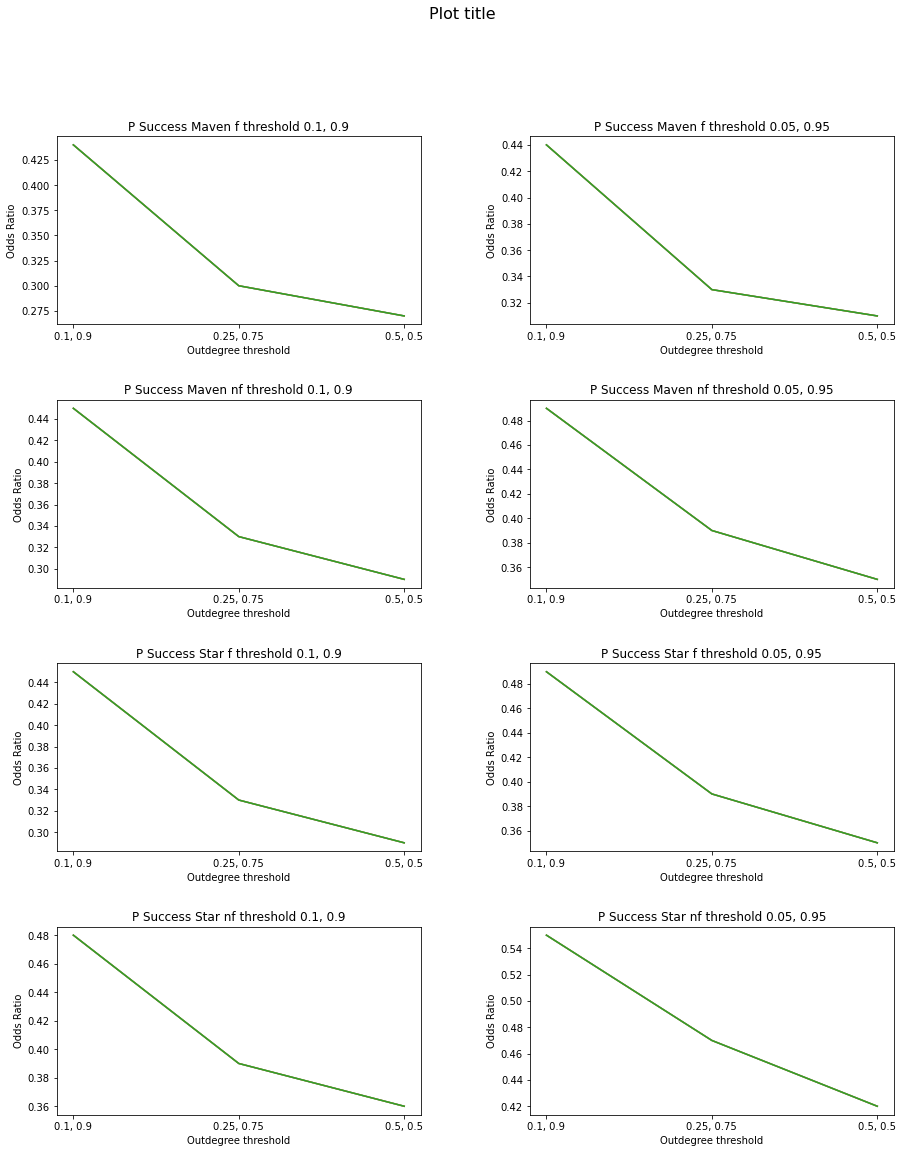

In [163]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# create a sample DataFrame
df = Robustness_table_2
# set the x-axis values
x = ['0.1, 0.9', '0.25, 0.75', '0.5, 0.5']

# set the subplot dimensions
nrows = 4
ncols = 2

# create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))

# loop over the rows and columns of the DataFrame
for i, row in enumerate(df.iterrows()):
    for j, (col_name, data) in enumerate(row[1].iteritems()):
        # get the subplot axis
        ax = axes[j // ncols, j % ncols]
        # plot the data on the subplot
        ax.plot(x, df[col_name], label=col_name)
        # set the title of the subplot to the column name (with underscores replaced by spaces)
        ax.set_title(col_name.replace("_", " "))
        # set the x-axis label
        ax.set_xlabel('Outdegree threshold')
        # set the y-axis label
        ax.set_ylabel('Odds Ratio')

# add a title to the entire plot
fig.suptitle('Plot title', fontsize=16)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# display the plot
plt.show()


In [221]:
df = Robustness_table.merge(Robustness_table_2, right_index = True, left_index = True)
df.columns = ['Q1_OR_Activity_threshold_0.1, 0.9',
       'Q1_OR_Activity_threshold_0.05, 0.95',
       'Q2_OR_Activity_threshold_0.1, 0.9',
       'Q2_OR_Activity_threshold_0.05, 0.95',
       'Q3_OR_Activity_threshold_0.1, 0.9',
       'Q3_OR_Activity_threshold_0.05, 0.95',
       'Q4_OR_Activity_threshold_0.1, 0.9',
       'Q4_OR_Activity_threshold_0.05, 0.95',
       'P(A|B)_Activity_threshold_0.1, 0.9',
       'P(A|B)_Activity_threshold_0.05, 0.95',
       'P(A|D)_Activity_threshold_0.1, 0.9',
       'P(A|D)_Activity_threshold_0.05, 0.95',
       'P(A|C)_Activity_threshold_0.1, 0.9',
       'P(A|C)_Activity_threshold_0.05, 0.95',
       'P(A|E)_Activity_threshold_0.1, 0.9',
       'P(A|E)_Activity_threshold_0.05, 0.95']

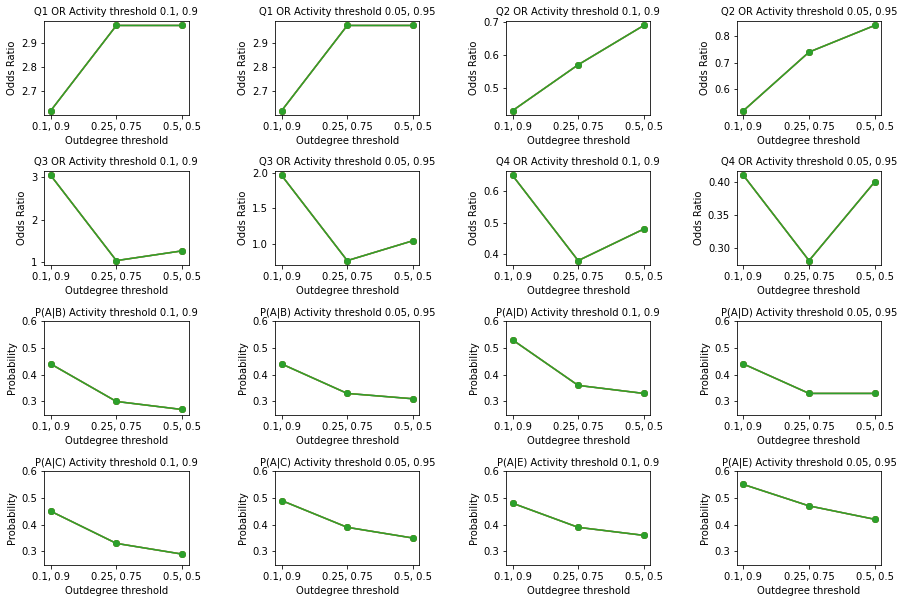

In [222]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# set the x-axis values
x = ['0.1, 0.9', '0.25, 0.75', '0.5, 0.5']

# set the subplot dimensions
nrows = 4
ncols = 4

# create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# loop over the rows and columns of the DataFrame
for i, row in enumerate(df.iterrows()):
    for j, (col_name, data) in enumerate(row[1].iteritems()):
        # get the subplot axis
        ax = axes[j // ncols, j % ncols]
        # plot the data on the subplot
        ax.plot(x, df[col_name],marker='o', label=col_name)
        # set the title of the subplot to the column name (with underscores replaced by spaces)
        ax.set_title(col_name.replace("_", " "), fontsize = 10)
        # set the x-axis label
        ax.set_xlabel('Outdegree threshold')       
        
        # set a fixed y-axis limit for the last 8 subplots
        if j >= 8:
            ax.set_ylabel('Probability')
            ax.set_ylim(0.25, 0.6)  # replace 0 and 10 with your desired lower and upper limits
        
        else:
            ax.set_ylabel('Odds Ratio')

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.6, hspace=0.6)

# display the plot
plt.show()


In [223]:
df

,"Q1_OR_Activity_threshold_0.1, 0.9","Q1_OR_Activity_threshold_0.05, 0.95","Q2_OR_Activity_threshold_0.1, 0.9","Q2_OR_Activity_threshold_0.05, 0.95","Q3_OR_Activity_threshold_0.1, 0.9","Q3_OR_Activity_threshold_0.05, 0.95","Q4_OR_Activity_threshold_0.1, 0.9","Q4_OR_Activity_threshold_0.05, 0.95","P(A|B)_Activity_threshold_0.1, 0.9","P(A|B)_Activity_threshold_0.05, 0.95","P(A|D)_Activity_threshold_0.1, 0.9","P(A|D)_Activity_threshold_0.05, 0.95","P(A|C)_Activity_threshold_0.1, 0.9","P(A|C)_Activity_threshold_0.05, 0.95","P(A|E)_Activity_threshold_0.1, 0.9","P(A|E)_Activity_threshold_0.05, 0.95"
"0.1, 0.9",2.62,2.62,0.43,0.52,3.04,1.96,0.65,0.41,0.44,0.44,0.53,0.44,0.45,0.49,0.48,0.55
"0.25, 0.75",2.97,2.97,0.57,0.74,1.03,0.76,0.38,0.28,0.3,0.33,0.36,0.33,0.33,0.39,0.39,0.47
"0.5, 0.5",2.97,2.97,0.69,0.84,1.26,1.04,0.48,0.4,0.27,0.31,0.33,0.33,0.29,0.35,0.36,0.42
